# Inverse autoregressive flows

__Objective:__ implement an inverse autoregressive normalizing flow (NF) for 2-dimensional data, then see how moving along a trajectory in "simple space" reflects onto the "complicated space".

Source: [here](https://github.com/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_04.ipynb) (section "Understanding the mixture")

**Idea:** define a NF parametrized by neural networks. For this to work, a number of requirements must be satisfied, in particular the flow (transformation) must be **invertible** and the Jacobian must be **lower triangular** and with diagonal components that can be computed quickly (so that the computation of the determinant is fast).

As with usual NF, we start from a probability density function $p_x$ in $d$ dimensions generating points $\mathbf{x}\in \mathbb{R}^d$ and we want to find a transformation $\mathbf{G}$ whose inverse maps it to another distribution $p_z$ that has a simple form, i.e. (in the "direct" direction) $\mathbf{x} = \mathbf{G}(\mathbf{z})$. The transformation law between the two distributions is
$$
p_x(x) = p_z(z)\, \left| \det\left( \left[ \frac{\partial G_i}{\partial z_j} \right] \right) \right|^{-1},
$$
the matrix $J\equiv \left[ \frac{\partial G_i}{\partial z_j} \right]$ being the Jacobian of the transformation.

Inverse autoregressive flows correspond to the followinf particular choice for the map $\mathbf{G}$:

$$
G_i = G_i(z_1, \ldots, z_i) = \exp\left( \alpha_i(z_1, \ldots, z_{i-1}) \right)\, z_i + b_i(z_1, \ldots, z_{i-1}),\quad i = 1, \ldots, d\,,
$$

with the "affine parameters" $\alpha_i$ and $b_i$ being given by neural networks and thus containing nonlinearities.

Observations:
- $G_i$ doesn't depend on $z_j$ if $j>i$: this creates a lower triangular Jacobian.
- $G_i$ depends on $z_i$ only in an affine way: this gives diagonal entries of $J$ that are easy to compute.
- $G_i$ depends on the $z_i$ for $i<j$ through $\alpha_i$ and $b_i$.
- The exponential is used so that the diagonal entries of $J$ are all positive, which gives an invertible transformation by construction.

The above form for $\mathbf{G}$ is achieved by using "autoregressive networks", which are implemented in Tensorflow Probability.

Tensorflow Probability provides the following implementations:
- `tfp.bijectors.Bijector`: the general class implementing an invertible transformation (a normalizing flow).
- `tfp.bijectors.MaskedAutoregressiveFlow`: the bijector implementing the full inverse autoregressive flow ("masked" refers to the fact that the NN used to get the parameters achieve the autoregressive properties via masking).
- `tfp.bijectors.AutoregressiveNetwork`: the bijector implementing the masked NN used to parametrize the inverse autoregressive flow.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions
tfb = tfp.bijectors

sns.set_theme()

## Generate data

In [2]:
n_samples = 2500

x2_samples = tfd.Normal(loc=0., scale=4.).sample(n_samples)

x1_samples = tfd.Normal(loc=.25 * tf.square(x2_samples), scale=tf.ones(n_samples, dtype=tf.float32)).sample()

samples = tf.stack(
    [x1_samples, x2_samples],
    axis=1
) / 40.

samples

2023-10-13 17:24:52.672554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(2500, 2), dtype=float32, numpy=
array([[ 0.02247221,  0.04882678],
       [ 0.47242707, -0.22566383],
       [-0.03140213, -0.01308205],
       ...,
       [ 0.03824791, -0.06078644],
       [ 0.04247139, -0.02995721],
       [ 0.08611818,  0.0793402 ]], dtype=float32)>

Text(0.5, 1.0, 'Samples')

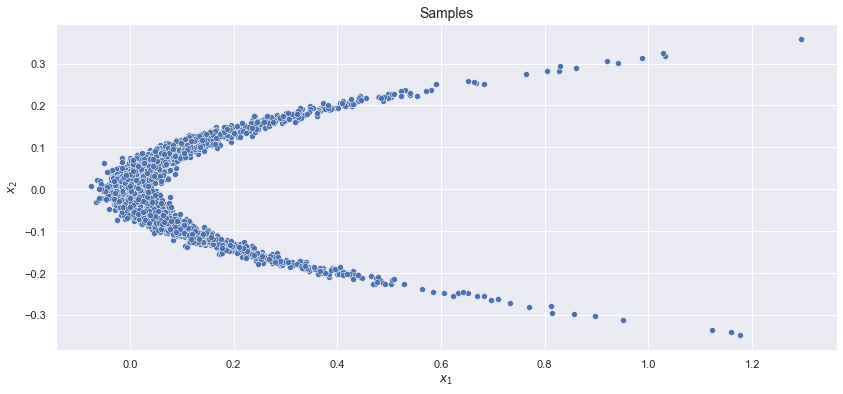

In [3]:
fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=samples[:, 0],
    y=samples[:, 1],
)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Samples', fontsize=14)

## Build an inverse autoregressive flow

In [4]:
class MaskedARFlow(tf.keras.Model):
    """
    Subclass of Keras `Model` implementing an inverse autoregressive
    flow (using masked autoregressive networks).
    """
    def __init__(self, n_layers=3, hidden_units=32, **kwargs):
        """
        Class constructor.
        """
        super().__init__()
        
        # List of the NNs giving the affine parameters.
        self.nets = []
        
        # List of all bijectors that will compose the
        # full one.
        bijectors = []
        
        # Number layers, each one composed of a
        # `MaskedAutoregressiveFLow` and a `Permute`
        # bijector.
        self.n_layers = n_layers
        self.hidden_units = hidden_units
        
        # Loop over the number of layers. Each layer is a block of bijecctors
        # that gets added to the list.
        for i in range(self.n_layers):
            # Creates the function building the NN parametrizing the affine
            # parameters (it's constructed so it can be passed to the
            # `shift_and_log_scale_fn` argument of the `MaskedAutoregressiveFlow`
            # bijector object.
            net = tfb.AutoregressiveNetwork(
                # This SHOULD be the number of parameters we want to generate (which
                # in our case should be the 2 affine parameters alpha and b).
                params=2,
                hidden_units=[self.hidden_units, self.hidden_units]
            )
            # Original code in source: doesn't work as the trainable variables are not
            # tracked!
            # net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            
            # Create a `MaskedAutoregressiveFlow` bijector and append it to the
            # list of bijectors.
            bijectors.append(
                tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net)
            )
            
            # Create a `Permute` bijector and append it to the list of bijectors.
            # The permutation passed to its constructor inverts the order of the
            # two dimensions so that no dimension is singled out in the procedure.
            # Note: this of course works only for 2 dimensions.
            bijectors.append(tfb.Permute([1, 0]))
            
            # Append the neural network to the list of the networks to keep track
            # of it.
            self.nets.append(net)
            
        # Create the full bijector defining the NF from the list of built bijectors
        # taken in reversed order. This way, in each block the permutation operation
        # is applied before the masked autoregressive flow. The last entry of the list
        # is dropped so that, in the reversed list, we don't start with a useless
        # permutation.
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        # Define the flow, i.e. the distribution object implementing the transformation
        # from a source simple distribution via the full bijector.
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            bijector=bijector
        )
        
    def call(self, *inputs):
        """
        Forward pass.
        """
        return self.flow.bijector.forward(*inputs)

Text(0.5, 1.0, 'Samples')

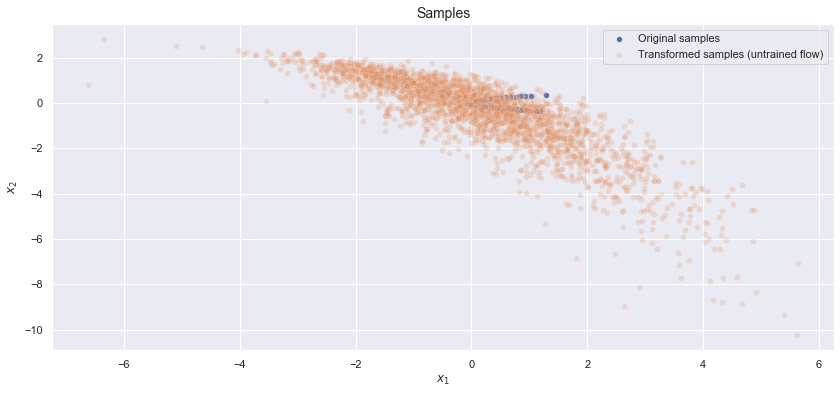

In [6]:
# Sample the source distribution and transform the samples via the
# untrained flow. This should give nothing sensible!
# Note: every time the model is instantiated, the NN weights
#       in it are re-initialized and a different transformation
#       is obtained.
transformed_samples_untrained = MaskedARFlow()(MaskedARFlow().flow.distribution.sample(2500))

fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=samples[:, 0].numpy(),
    y=samples[:, 1].numpy(),
    label='Original samples'
)

sns.scatterplot(
    x=transformed_samples_untrained[:, 0].numpy(),
    y=transformed_samples_untrained[:, 1].numpy(),
    label='Transformed samples (untrained flow)',
    alpha=.2
)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Samples', fontsize=14)

### Training

The inverse autoregressive flow is a bijector depending on trainable parameters that can be optimized by minimizing a loss function. The chosen loss is the negative log likelihood of the data w.r.t. to the transformed distribution: in the optimal case, sampling from the transformed distribution (i.e. sampling the simple distribution $p_x$ and then mapping the samples via the flow) should produce something similar to the original data, sampled from $p_z$.

In [7]:
def nll(samples, distr):
    """
    Negative log likelihood of `samples` according to the
    distribution `distr`.
    """
    return - tf.reduce_mean(distr.log_prob(samples))

In [8]:
model = MaskedARFlow(n_layers=3, hidden_units=32)

loss_history = []

# Just a call on some input to build the model
# (it needs it to infer the input shape).
model(tf.random.uniform((10, 2)))

model.summary()

Model: "masked_ar_flow_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoregressive_network_12 (  multiple                 1284      
 AutoregressiveNetwork)                                          
                                                                 
 autoregressive_network_13 (  multiple                 1284      
 AutoregressiveNetwork)                                          
                                                                 
 autoregressive_network_14 (  multiple                 1284      
 AutoregressiveNetwork)                                          
                                                                 
Total params: 3,852
Trainable params: 3,852
Non-trainable params: 0
_________________________________________________________________


2023-10-13 17:26:18.880272: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
@tf.function
def training_step(x):
    with tf.GradientTape() as tape:
        loss = nll(x, model.flow)
        
    grad = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss

In [12]:
# Training loop without minibatches.
# epochs = 5000
# learning_rate = 1e-3
# 
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# 
# for i in range(epochs):
#     # with tf.GradientTape() as tape:
#     #     loss = nll(samples, model.flow)
#     loss = training_step(samples)
# 
#     loss_history.append(loss.numpy())
# 
#     # grad = tape.gradient(loss, model.trainable_variables)
# 
#     # optimizer.apply_gradients(zip(grad, model.trainable_variables))
#     
#     if (i < 10) or (i % 500 == 0):
#         print(f'Epoch: {i} | Loss: {loss_history[-1]}')
#     
# loss_history.append(nll(samples, model.flow).numpy())

In [13]:
# Training loop with minibatches.
epochs = 2000
learning_rate = 1e-3
batch_size = 256

n_batches = tf.floor(samples.shape[0] / batch_size).numpy().astype(int)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Loop over epochs.
for i in range(epochs):
    losses = []
    
    # Loop over minibatches.
    for j in range(n_batches):
        batch = tf.gather(
            samples,
            tf.random.uniform(minval=0, maxval=samples.shape[0], shape=(batch_size,), dtype=tf.int32)
        )

        loss = training_step(batch)

        losses.append(loss.numpy())
        
    # Epoch loss is the average loss across batches.
    loss_history.append(tf.reduce_mean(losses).numpy())
    
    if (i < 10) or (i % 200 == 0):
        print(f'Epoch: {i} | Loss: {loss_history[-1]}')
    
loss_history.append(nll(samples, model.flow).numpy())

Epoch: 0 | Loss: 1.535670518875122
Epoch: 1 | Loss: 1.2294797897338867
Epoch: 2 | Loss: 0.9766638278961182
Epoch: 3 | Loss: 0.8791006207466125
Epoch: 4 | Loss: 0.7343637943267822
Epoch: 5 | Loss: 0.5432237386703491
Epoch: 6 | Loss: 0.3523359000682831
Epoch: 7 | Loss: 0.19288820028305054
Epoch: 8 | Loss: -0.035387009382247925
Epoch: 9 | Loss: -0.2361539751291275
Epoch: 200 | Loss: -3.0906035900115967
Epoch: 400 | Loss: -2.926466226577759
Epoch: 600 | Loss: -3.075300931930542
Epoch: 800 | Loss: -3.07084584236145
Epoch: 1000 | Loss: -2.834388017654419
Epoch: 1200 | Loss: -3.09177565574646
Epoch: 1400 | Loss: -3.0803308486938477
Epoch: 1600 | Loss: -3.0469350814819336
Epoch: 1800 | Loss: -3.0555782318115234


Text(0.5, 1.0, 'Samples')

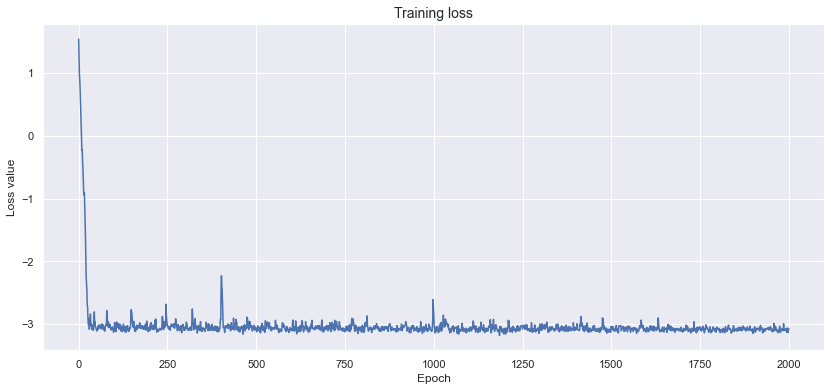

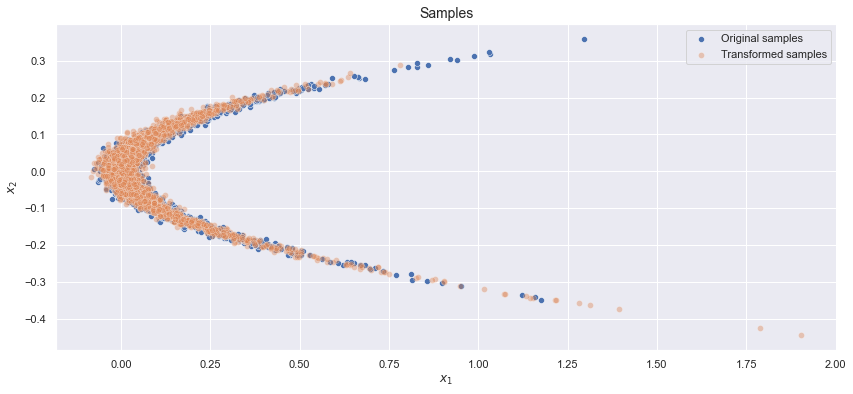

In [15]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=range(len(loss_history)),
    y=loss_history
)

plt.title('Training loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss value')


fig = plt.figure(figsize=(14, 6))

# Sample the source distribution and transform the samples via the
# trained flow. This should give something that looks much more
# like the original samples, as the flow should have understood
# how to map the simple space into the complicated one.
transformed_samples = model.flow.sample(2500)

sns.scatterplot(
    x=samples[:, 0].numpy(),
    y=samples[:, 1].numpy(),
    label='Original samples'
)

sns.scatterplot(
    x=transformed_samples[:, 0].numpy(),
    y=transformed_samples[:, 1].numpy(),
    label='Transformed samples',
    alpha=.4
)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Samples', fontsize=14)

## Explore trajectories

Text(0.5, 1.0, 'Complicated space (distr. $p_x$)')

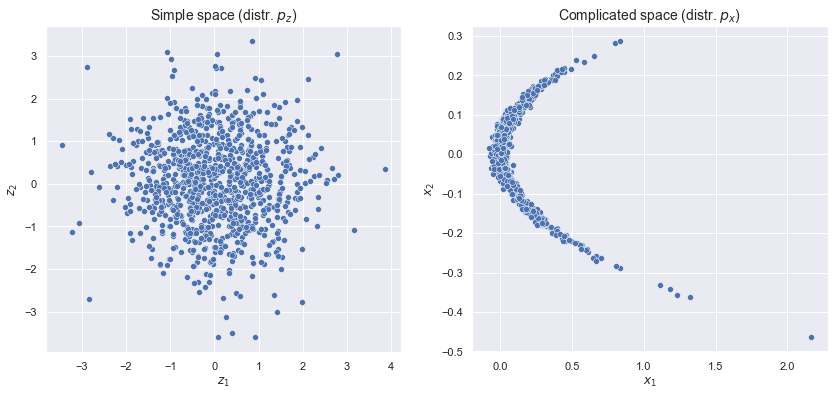

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

z_samples = model.flow.distribution.sample(1000)

sns.scatterplot(
    x=z_samples[:, 0],
    y=z_samples[:, 1],
    ax=axs[0]
)

plt.sca(axs[0])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Simple space (distr. $p_z$)', fontsize=14)

x_samples = model.flow.sample(1000)

sns.scatterplot(
    x=x_samples[:, 0],
    y=x_samples[:, 1],
    ax=axs[1]
)

plt.sca(axs[1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Complicated space (distr. $p_x$)', fontsize=14)

Let's define a trajectory in the simple space and see what it corresponds to in the complicated space.

**Question:** what if the trajectory in the complicated space appears not to be continuous?

In [19]:
# Starting point and endpoint of the trajectory in x-space.
# Note: these points were chosen because, at least in one case,
#       they corresponded to nice points of either side of
#       the complicated distribution.
z_start = tf.constant([[0.5805478, -1.828414]])
z_end = tf.constant([[-0.42988047, 2.0904593]])

# Trajectory (a straight line).
z_traj = tf.concat(
    [
        z_start + t * (z_end - z_start)
        for t in tf.linspace(0., 1., 20)
    ],
    axis=0
)

# Mapping of the trajectory to z-space via the flow.
x_traj = model.flow.bijector.forward(z_traj)

Text(0.5, 1.0, 'Complicated space (distr. $p_x$)')

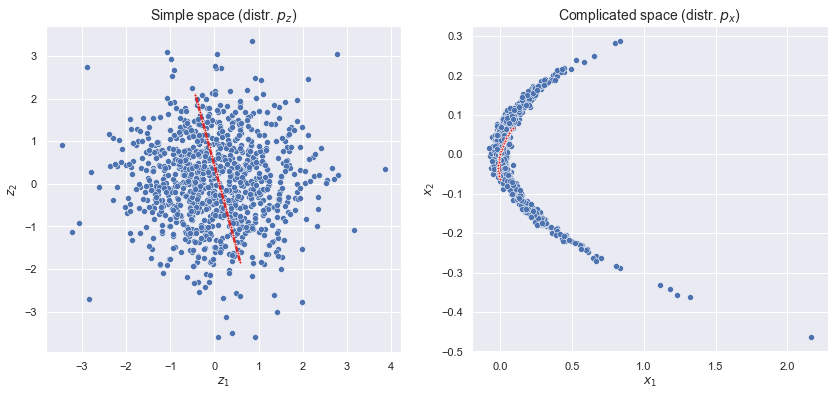

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.scatterplot(
    x=z_samples[:, 0],
    y=z_samples[:, 1],
    ax=axs[0]
)

sns.lineplot(
    x=z_traj[:, 0],
    y=z_traj[:, 1],
    ax=axs[0],
    color=sns.color_palette("tab10")[3],
    linewidth=2.5,
    marker='.'
)

plt.sca(axs[0])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Simple space (distr. $p_z$)', fontsize=14)

sns.scatterplot(
    x=x_samples[:, 0],
    y=x_samples[:, 1],
    ax=axs[1]
)

sns.lineplot(
    x=x_traj[:, 0],
    y=x_traj[:, 1],
    ax=axs[1],
    color=sns.color_palette("tab10")[3],
    linewidth=1.5,
    marker='.'
)

plt.sca(axs[1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Complicated space (distr. $p_x$)', fontsize=14)